In [53]:
# ! git clone https://github.com/seshuad/IMagenet
# ! ls 'IMagenet/tiny-imagenet-200/'

In [54]:
# !pip install -U tensorflow-addons

In [55]:
import time
import scipy.ndimage as nd
import scipy.misc
import cv2
import numpy as np
import os
import glob
import gc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageEnhance
from random import randint
import pandas as pd
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from google.colab.patches import cv2_imshow
import plotly.graph_objects as go
%matplotlib inline

In [56]:
import random as rn
np.random.seed(4321)
rn.seed(4321)
tf.random.set_seed(4321)

Extract test and training data from Tiny ImageNet DataSet

In [57]:
# cnt = 0
# for file in os.listdir(path):
#     print(file)
#     cnt += 1
#     if(cnt==5):
#         break
    

In [58]:
def rotate_image():
  return randint(0,3)

def sharpen_image():
  return randint(0,3)

In [59]:
IM_WIDTH = IM_HEIGHT = 64
TRAIN_TEST_SPLIT = 0.8
dataset_dict = {
    'saturation_id': {
        0: '0.0',
        1: '0.25',
        2: '0.75',
        3: '1.0' 
    },
    'sharpness_id': {
        0: '0.0',
        1: '0.25',
        2: '0.75',
        3: '1.0'
    }
}
dataset_dict['saturation_alias'] = dict((r, i) for i, r in dataset_dict['saturation_id'].items())
dataset_dict['sharpness_alias'] = dict((s, i) for i, s in dataset_dict['sharpness_id'].items())

In [60]:
def prepare_dataset(dataset, ext='JPEG'):
    def generate_rotate_sharp():
      res_rot = rotate_image()
      res_sharp = sharpen_image()
      return [res_rot, res_sharp]
    
    records = []
    for filename in os.listdir(dataset):
        info = generate_rotate_sharp()
        records.append(info+[dataset+'/'+filename])
        
    df = pd.DataFrame(records)
    df.columns = ['saturation_id', 'sharpness_id', 'image']
    df = df.dropna()
    
    return df

path = '../input/celebahq-resized-256x256/celeba_hq_256'
df = prepare_dataset(path)
df.head()

saturation_id  sharpness_id  \
0              2             0   
1              3             0   
2              1             2   
3              0             0   
4              1             0   

                                               image  
0  ../input/celebahq-resized-256x256/celeba_hq_25...  
1  ../input/celebahq-resized-256x256/celeba_hq_25...  
2  ../input/celebahq-resized-256x256/celeba_hq_25...  
3  ../input/celebahq-resized-256x256/celeba_hq_25...  
4  ../input/celebahq-resized-256x256/celeba_hq_25...

In [61]:
def plot_distribution(pd_series, key):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    labels = list(map(lambda id: dataset_dict[key][id], labels))
    # self.df['saturation_id'] = self.df['saturation'].map(lambda saturation: dataset_dict['saturation_alias'][saturation])
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [62]:
plot_distribution(df['saturation_id'], 'saturation_id')

In [63]:
plot_distribution(df['sharpness_id'], 'sharpness_id')

In [64]:
def get_random_crop(image, crop_height, crop_width):

    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop

# example_image = np.random.randint(0, 256, (1024, 1024, 3))
# random_crop = get_random_crop(example_image, 64, 64)

In [65]:
class ImgDataGenerator():
    """
    Data generator for the Tiny imagenet dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_val_idx = self.df.tail(train_up_to)
        test_idx = self.df.head(len(self.df) - train_up_to)
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_val_idx = train_val_idx.sample(frac=1).reset_index(drop=True)
        train_idx, valid_idx = train_val_idx.tail(train_up_to), train_val_idx.head(len(train_val_idx) - train_up_to)
        
        return train_idx, valid_idx, test_idx
    
    
    def preprocess_image(self, sharpen: int, sat: int, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im_cv = cv2.imread(img_path)
        im = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
        # Crop the image to 224 x 224
        im = get_random_crop(im, 224, 224)
        
        # Continue preprocessing
        enhancer = ImageEnhance.Sharpness(Image.fromarray(im))
        sharpness = 0.
        if sharpen == 1:
          sharpness = 0.25
          # out = unsharp_mask(im, amount=0.5)
        elif sharpen == 2:  
          sharpness = 0.75
          # out = unsharp_mask(im, amount = 1.5)
        elif sharpen >= 3:
          sharpness = 1.
          # out = unsharp_mask(im, amount = 2.5)
        
        out = np.array(enhancer.enhance(sharpness))
        
        enhancer = ImageEnhance.Color(Image.fromarray(out))
        saturation = 0.
        if sat == 1:
          saturation = 0.25
          # out = unsharp_mask(im, amount=0.5)
        elif sat == 2:  
          saturation = 0.75
          # out = unsharp_mask(im, amount = 1.5)
        elif sat >= 3:
          saturation = 1.
          # out = unsharp_mask(im, amount = 2.5)
        
        out = np.array(enhancer.enhance(saturation))
        # print(out.shape)
        out = out / 255.0
        return out
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, saturations, sharps = [], [], []
        while True:
            for idx in range(len(image_idx)):
                row = image_idx.iloc[idx]
                
                saturation = row['saturation_id']
                sharpness = row['sharpness_id']
                img_path = row['image']
                
                im = self.preprocess_image(saturation, sharpness, img_path)
                
                cat_rot = to_categorical(saturation, 4)
                cat_sharp = to_categorical(sharpness, 4)
                saturations.append(cat_rot)
                sharps.append(cat_sharp)
                # print("saturation = ",saturation,"cat_rot = ",cat_rot)
                # print("sharpness = ",sharpness,"cat_sharp = ",cat_sharp)
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(saturations), np.array(sharps)]
                    images, saturations, sharps = [], [], []
                    
            if not is_training:
                break
                
data_generator = ImgDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [66]:
print(train_idx.shape)
print(valid_idx.shape)
print(test_idx.shape)

(19200, 3)
(4800, 3)
(6000, 3)


In [67]:
# print(test_idx.head())
# print(type(test_idx))

In [68]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [69]:
DEBUG = 0
if DEBUG:
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    data_gen = data_generator.generate_images(test_idx, is_training=False, batch_size=8)
  # images = data_gen[0]
    for i,data in enumerate(data_gen):
        images, outputs = data
        print(len(images))
#         for j, image in enumerate(images):
#             image *= 255.0
#             print("saturation ",outputs[0][j])
#             print("sharpness ",outputs[1][j])
#             grid.imshow(image)
            
        for ax, im in zip(grid, images):
            # Iterating over the grid returns the Axes.
            ax.imshow(im)

        plt.show()
        break

In [70]:
kernel = (3,3)
pool = (2,2)
upstride = (2,2)
activation = 'relu'
class inpaintingModel:
  def build_encoder(self, inputs):
    # inputs = keras.layers.Input(input_size)
    conv1, pool1 = self.__ConvBlock(64, kernel, pool, activation, 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(128, kernel, pool, activation, 'same', pool1)
    conv3, pool3 = self.__ConvBlock(256, kernel, pool, activation, 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(512, kernel, pool, activation, 'same', pool3) 
    conv5, pool5 = self.__ConvBlock(1024, kernel, pool, activation, 'same', pool4)

    return conv1, conv2, conv3, conv4, conv5, pool5

  def build_decoder(self, conv1, conv2, conv3, conv4, conv5, pool_layer):
    conv6, up7 = self.__UpConvBlock(2048, 1024, kernel, pool, upstride, activation, 'same', pool_layer, conv5)
    conv7, up8 = self.__UpConvBlock(1024, 512, kernel, pool, upstride, activation, 'same', up7, conv4)
    conv8, up9 = self.__UpConvBlock(512, 256, kernel, pool, upstride, activation, 'same', up8, conv3)
    conv9, up10 = self.__UpConvBlock(256, 128, kernel, pool, upstride, activation, 'same', up9, conv2)
    conv10, up11 = self.__UpConvBlock(128, 64, kernel, pool, upstride, activation, 'same', up10, conv1)

    conv11 = self.__ConvBlock(32, kernel, pool, activation, 'same', up11, False)
    
    outputs = keras.layers.Conv2D(3, kernel, activation='sigmoid', padding='same')(conv11)

    return outputs
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(224,224,3)):
    inputs = keras.layers.Input(input_size)
    conv1, conv2, conv3, conv4, conv5, pool_layer = self.build_encoder(inputs)
    outputs = self.build_decoder(conv1, conv2, conv3, conv4, conv5, pool_layer)
    # conv1, pool1 = self.__ConvBlock(64, kernel, pool, activation, 'same', inputs) 
    # conv2, pool2 = self.__ConvBlock(128, kernel, pool, activation, 'same', pool1)
    # conv3, pool3 = self.__ConvBlock(256, kernel, pool, activation, 'same', pool2) 
    # conv4, pool4 = self.__ConvBlock(512, kernel, pool, activation, 'same', pool3) 
    # conv5, pool5 = self.__ConvBlock(1024, kernel, pool, activation, 'same', pool4)
     

    # conv6, up7 = self.__UpConvBlock(2048, 1024, kernel, pool, upstride, activation, 'same', pool5, conv5)
    # conv7, up8 = self.__UpConvBlock(1024, 512, kernel, pool, upstride, activation, 'same', up7, conv4)
    # conv8, up9 = self.__UpConvBlock(512, 256, kernel, pool, upstride, activation, 'same', up8, conv3)
    # conv9, up10 = self.__UpConvBlock(256, 128, kernel, pool, upstride, activation, 'same', up9, conv2)
    # conv10, up11 = self.__UpConvBlock(128, 64, kernel, pool, upstride, activation, 'same', up10, conv1)

    # conv11 = self.__ConvBlock(64, kernel, pool, activation, 'same', up11, False)
    
    # outputs = keras.layers.Conv2D(3, kernel, activation='sigmoid', padding='same')(conv11)
    # inpur
    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [71]:
class pretextModel:
  def assemble_head_branch(self,  pool_layer, name):
    x = Flatten()(pool_layer)
    x = Dense(512)(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
        
    # x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    # x = Dense(2048, 
    #           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    #           bias_regularizer=tf.keras.regularizers.l2(1e-4),
    #           activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dense(512)(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(4)(x)
    x = Activation("softmax", name=name)(x)
    return x

  def assemble_pretext_model(self):
    inputs = keras.layers.Input((224,224,3))
    conv1, conv2, conv3, conv4, conv5, pool_layer = inpaintingModel().build_encoder(inputs) 
    saturation_branch = self.assemble_head_branch(pool_layer, "saturation_output")
    sharpness_branch = self.assemble_head_branch(pool_layer, "sharpness_output")
    model = Model(inputs=inputs,
                  outputs = [saturation_branch, sharpness_branch],
                  name="pretext_net")
    return model

In [72]:
from tensorflow import keras
keras.backend.clear_session()

In [73]:
p_model = pretextModel().assemble_pretext_model()

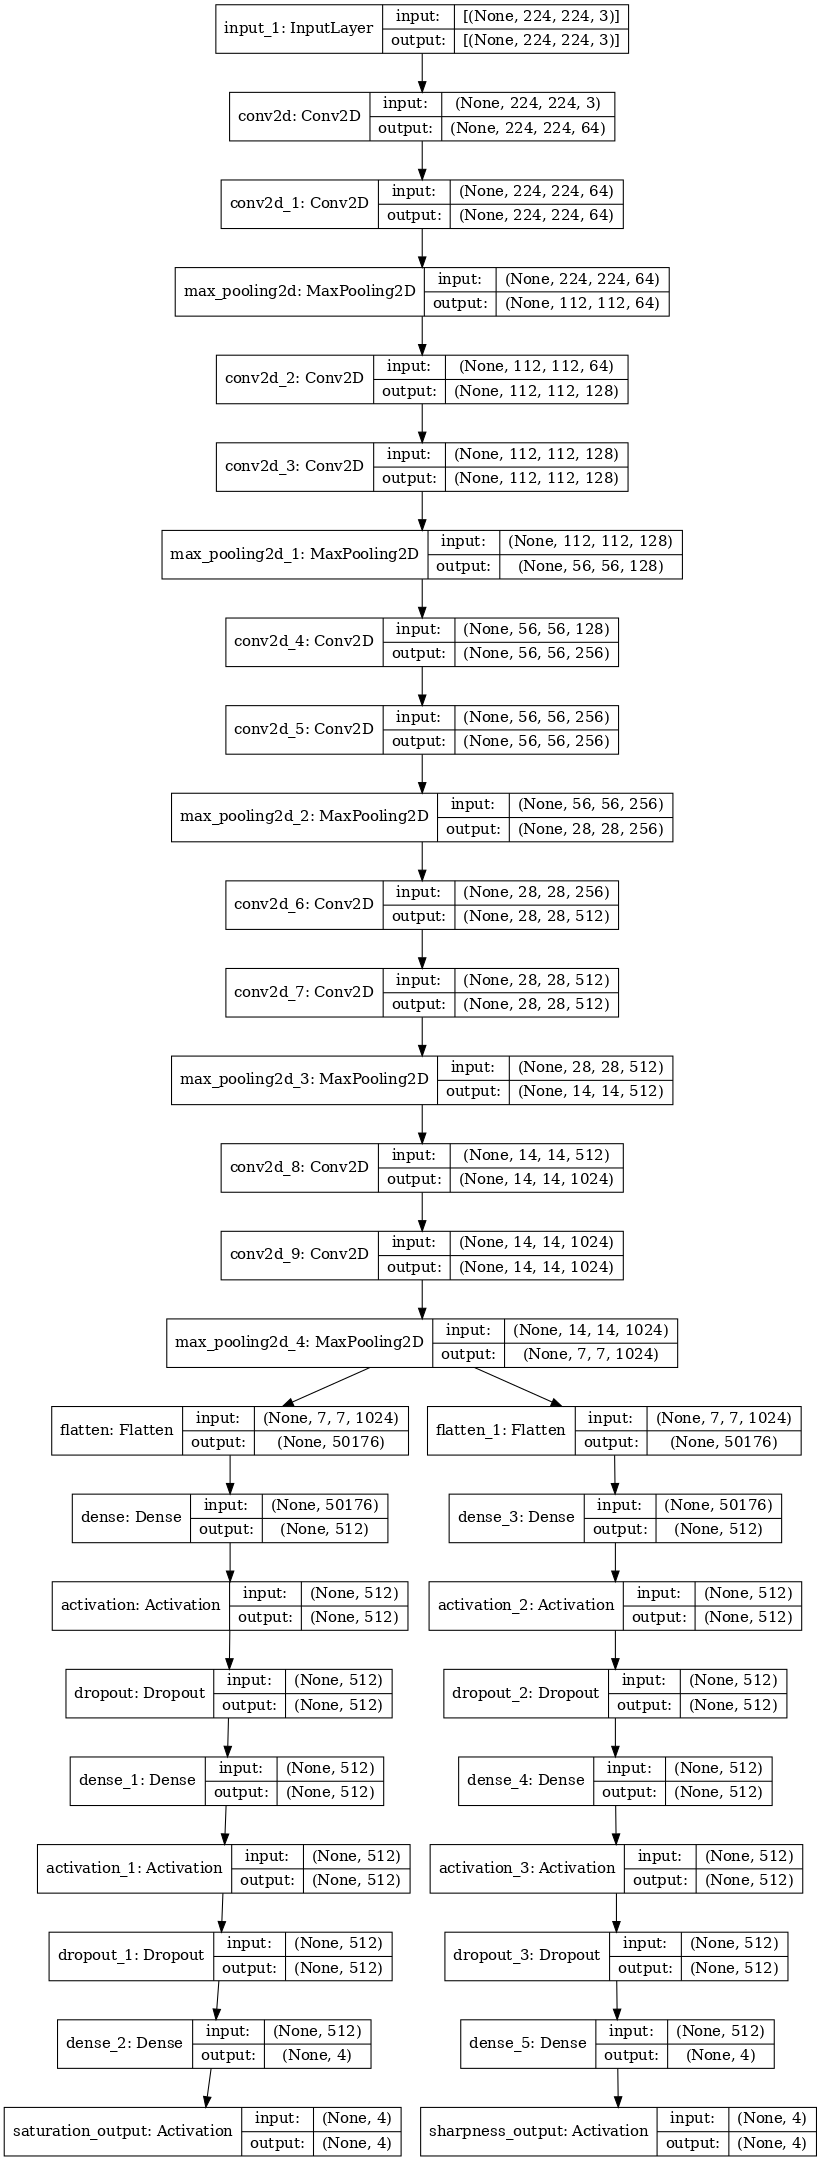

In [74]:
tf.keras.utils.plot_model(p_model, show_shapes=True, dpi=76, to_file='p_model_v1.png')

In [75]:
p_model.summary()

Model: "pretext_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [76]:
init_lr = 1e-4
epochs = 40
opt = Adam(learning_rate=init_lr, amsgrad=False)
p_model.compile(optimizer=opt, 
              loss={
                  'saturation_output': 'categorical_crossentropy', 
                  'sharpness_output': 'categorical_crossentropy'},
              
              loss_weights={
                  'saturation_output': 0.1, 
                  'sharpness_output': 0.9},
              metrics={
                  'saturation_output': 'accuracy',
                  'sharpness_output': 'accuracy'})

In [77]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("./p_model_checkpoint", monitor='val_loss')
batch_size = 64
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=batch_size)
callbacks = [early_stopping, checkpoint]
history = p_model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
#                     callbacks=callbacks,
                    # class_weight=dict(
                    #     saturation_output = rots_dict,
                    #     sharpness_output = sharps_dict
                    # ), 
                    # use_multiprocessing=True,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//batch_size)

Epoch 1/40
300/300 [==============================] - 291s 969ms/step - loss: 0.8058 - saturation_output_loss: 1.3985 - sharpness_output_loss: 0.7399 - saturation_output_accuracy: 0.2492 - sharpness_output_accuracy: 0.6139 - val_loss: 0.6144 - val_saturation_output_loss: 1.3878 - val_sharpness_output_loss: 0.5285 - val_saturation_output_accuracy: 0.2606 - val_sharpness_output_accuracy: 0.7577
Epoch 2/40
300/300 [==============================] - 189s 632ms/step - loss: 0.5787 - saturation_output_loss: 1.3900 - sharpness_output_loss: 0.4885 - saturation_output_accuracy: 0.2481 - sharpness_output_accuracy: 0.7580 - val_loss: 0.4618 - val_saturation_output_loss: 1.3864 - val_sharpness_output_loss: 0.3591 - val_saturation_output_accuracy: 0.2515 - val_sharpness_output_accuracy: 0.8238
Epoch 3/40
300/300 [==============================] - 193s 643ms/step - loss: 0.4891 - saturation_output_loss: 1.3871 - sharpness_output_loss: 0.3894 - saturation_output_accuracy: 0.2528 - sharpness_output_ac

In [78]:
# c

In [79]:
def plot_metric(metric):
  plt.clf()
  fig = go.Figure(layout_yaxis_range=[0,2])
  fig.add_trace(go.Scatter(
                      y=history.history[metric],
                      name='Train'))
  fig.add_trace(go.Scatter(
                      y=history.history['val_'+metric],
                      name='Valid'))
  fig.update_layout(height=500, 
                    width=700,
                    title=metric,
                    xaxis_title='Epoch',
                    yaxis_title='Accuracy/Loss')
  fig.show()

metrics = ['saturation_output_accuracy', 'saturation_output_loss', 'sharpness_output_accuracy', 'sharpness_output_loss', 'loss']
for i in metrics:
    plot_metric(i)

<Figure size 432x288 with 0 Axes>

In [80]:
p_model.save('sha-sat-70_30.h5')
# from tensorflow.keras.models import load_model
# p_model = load_model('../input/pretexttaskmodel/rot-sha-30_70/rot-sha-30_70.h5')

In [81]:
test_batch_size = 64 # 256
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
saturation_pred, sharpness_pred= p_model.predict(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

In [82]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, saturation_true, sharpness_true = [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    saturation_true.extend(labels[0])
    sharpness_true.extend(labels[1])
    
saturation_true = np.array(saturation_true)
sharpness_true = np.array(sharpness_true)
saturation_true, sharpness_true = saturation_true.argmax(axis=-1), sharpness_true.argmax(axis=-1)
saturation_pred, sharpness_pred = saturation_pred.argmax(axis=-1), sharpness_pred.argmax(axis=-1)


In [83]:
cr_saturation = classification_report(saturation_true, saturation_pred, target_names=dataset_dict['saturation_alias'].keys())
print(cr_saturation)

              precision    recall  f1-score   support

         0.0       0.69      0.61      0.64      1514
        0.25       0.50      0.50      0.50      1481
        0.75       0.43      0.36      0.39      1479
         1.0       0.57      0.72      0.64      1478

    accuracy                           0.55      5952
   macro avg       0.55      0.55      0.54      5952
weighted avg       0.55      0.55      0.54      5952



In [84]:
cr_sharpness = classification_report(sharpness_true, sharpness_pred, target_names=dataset_dict['sharpness_alias'].keys())
print(cr_sharpness)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1513
        0.25       1.00      1.00      1.00      1492
        0.75       0.89      0.94      0.91      1491
         1.0       0.94      0.88      0.91      1456

    accuracy                           0.95      5952
   macro avg       0.96      0.95      0.95      5952
weighted avg       0.96      0.95      0.95      5952



In [85]:
# mask_path = '../input/quick-draw-irregular-mask-dataset/qd_imd'
mask_path = '../input/qd-30-50/qd_imd'

In [86]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, mask_path, is_training, batch_size=128, dim=(224, 224), n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size 
        self.df = df
        self.mask_path = mask_path
        self.is_training = is_training
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs):
        # X_batch is a matrix of masked images used as input
        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
        # y_batch is a matrix of original images used for computing error from reconstructed image
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

        ## Iterate through random indexes
        for i, idx in enumerate(idxs):
            # image_copy = self.X[idx].copy()
#             print(self.df.iloc[idx]['image'])
            image_copy = cv2.imread(self.df.iloc[idx]['image'])
            image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
            # Crop the image to 224 x 224
            image_copy = get_random_crop(image_copy, 224, 224)

            ## Get mask associated to that image
            masked_image = self.__createMask(image_copy)

            X_batch[i,] = masked_image/255
            y_batch[i] = image_copy/255

        return X_batch, y_batch

    def __createMask(self, img):
        directory = "Unknown"
        mask_no = -1
        if(self.is_training):
            directory = 'train'
            mask_no = np.random.randint(0,14991-1)
        else:
            directory = 'test'
            mask_no = np.random.randint(0,3122-1)
            
        # Pad the mask_no
        mask_no = str(mask_no).zfill(5)
        
        img_path = self.mask_path+'/'+ directory + '/' + mask_no + '_'+ directory + '.png'
        mask = cv2.imread(img_path)
#         mask = cv2.resize(mask, (256,256))
#         mask = get_random_crop(mask, 224, 224)
        
#         thresh = 127
#         mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
#         print(type(img), type(mask))
#         print(img.shape, mask.shape)
        masked_image = cv2.bitwise_and(img, mask)

        return masked_image

In [87]:
# x_train, y_train, x_test, y_test = get_data(get_id_dictionary())

In [88]:
## Prepare training and testing mask-image pair generator
d_train_gen = createAugment(train_idx, mask_path, is_training = 1, batch_size=64)
d_test_gen = createAugment(test_idx, mask_path, is_training = 0, shuffle=False, batch_size=64)

In [89]:
from mpl_toolkits.axes_grid1 import ImageGrid

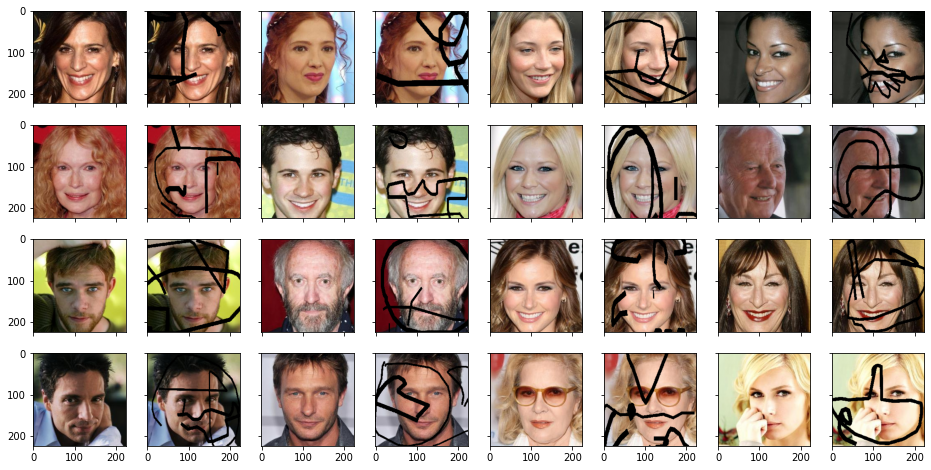

In [90]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = d_train_gen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
    ax.imshow(image)

plt.show()

In [91]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
from sklearn.metrics import jaccard_score

def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def ssim_loss(y_true, y_pred):
    return 1 - SSIM(y_true, y_pred, multichannel=True)

def ssim_coef(y_true, y_pred):
    return 1 - SSIM(y_true, y_pred, multichannel=True)

def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
def custom_loss(y_true, y_pred):
    alpha = 0.84
    loss_ssim = SSIMLoss(y_true, y_pred)
    
#     jaccard_dist = jaccard_score(y_true.flatten(), y_pred.flatten())
#     jaccard_dist = jaccard_distance(y_true, y_pred)
    logcosh = tf.keras.losses.logcosh(y_true, y_pred)
#     loss_mae = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return (1-alpha)*loss_ssim + alpha*logcosh

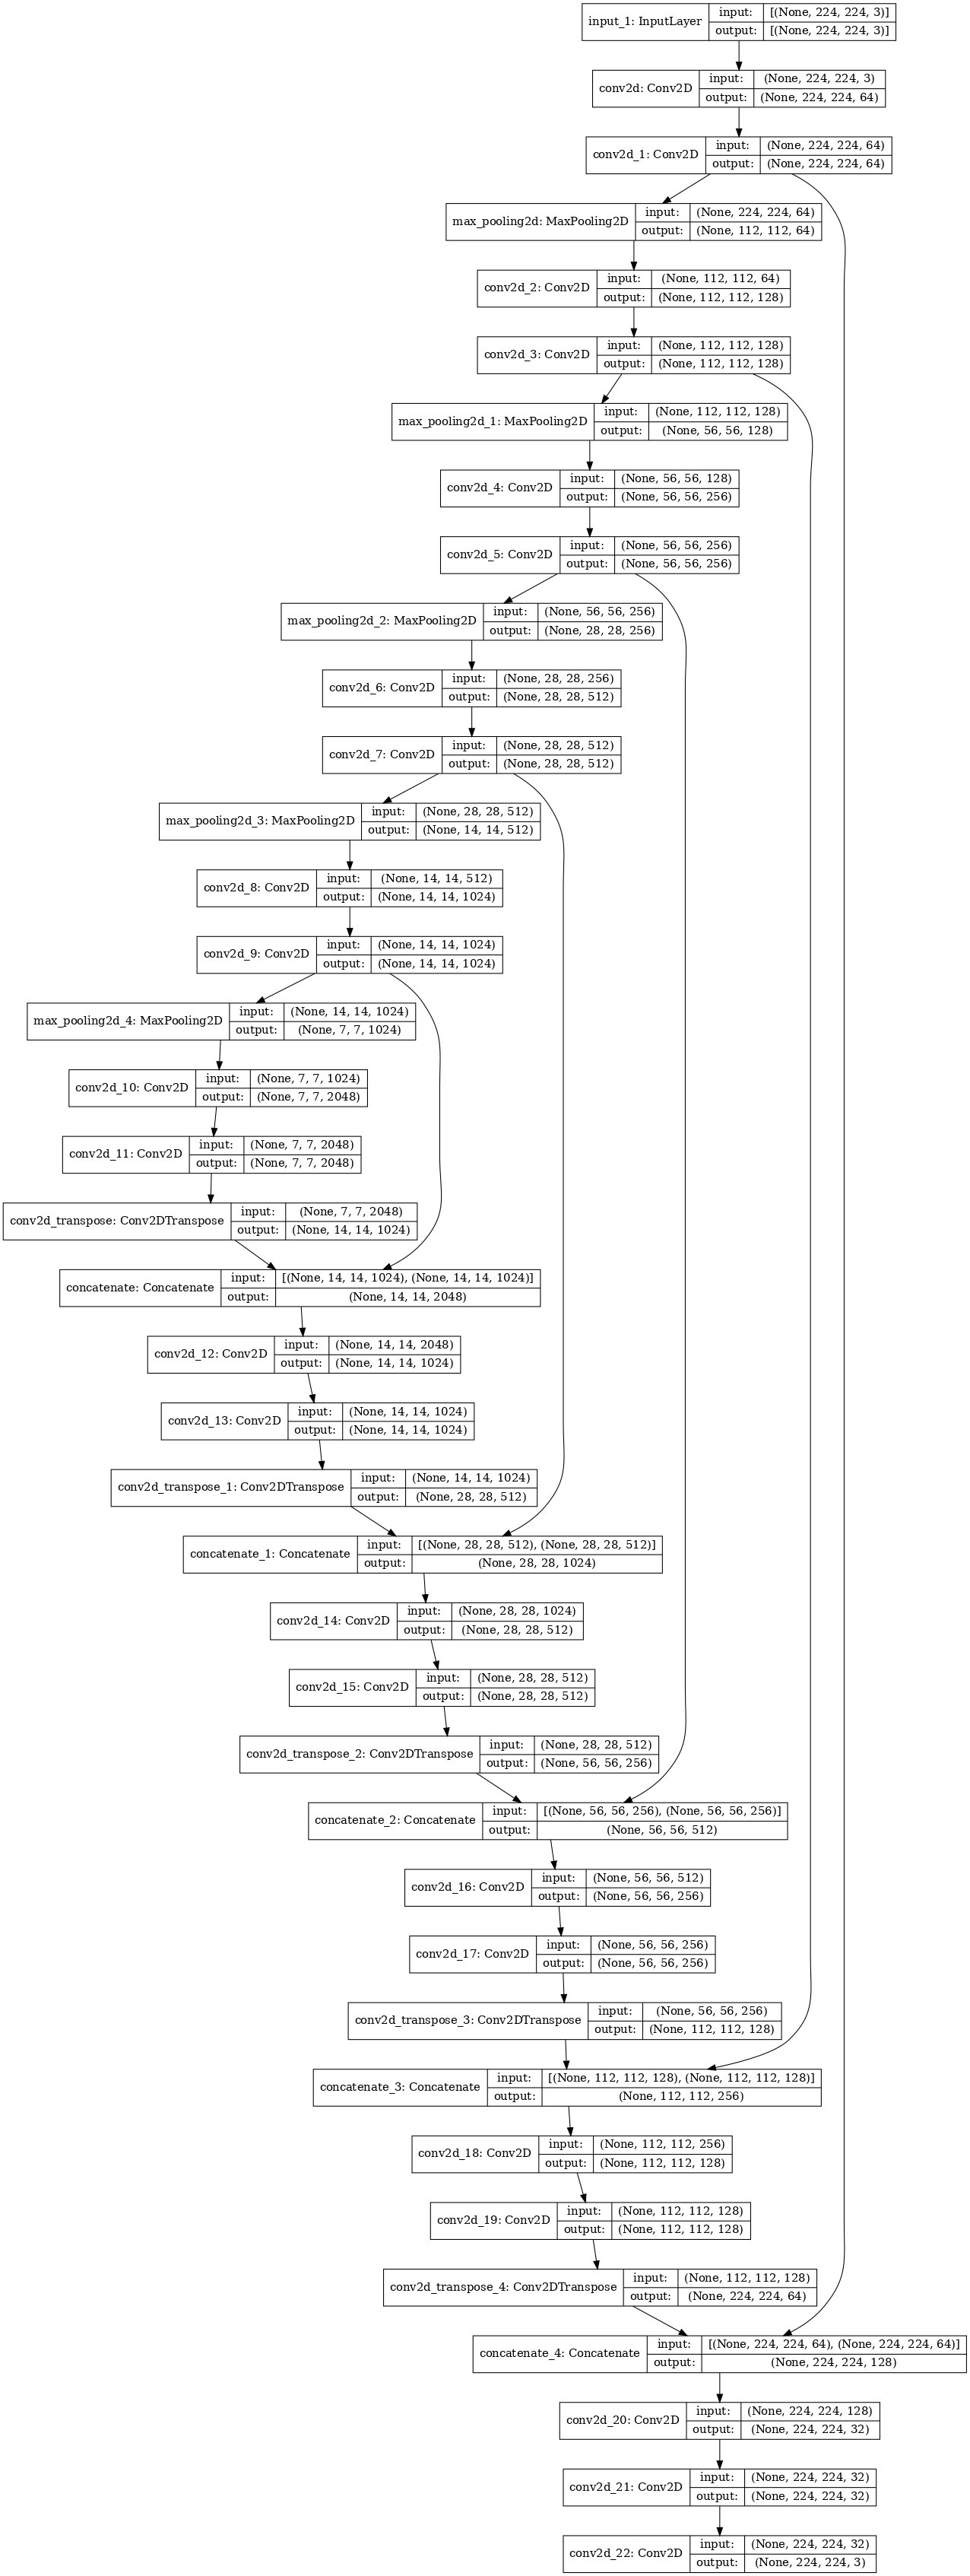

In [92]:
keras.backend.clear_session()
d_model = inpaintingModel().prepare_model()
depth = 16
init_lr = 1e-4
opt = Adam(learning_rate=init_lr, amsgrad=False)
  # d_model.layers[:depth]:
  # print(i)
  # layer.set_weights(p_model.layers)
  # d_model.trainable_weights[i].assign(p_model.trainable_weights[i])
for i in range(depth):
    d_model.layers[i].set_weights(p_model.layers[i].get_weights())
    d_model.layers[i].trainable = False
d_model.compile(optimizer=opt, loss= [custom_loss], metrics=[dice_coef], 
#                 run_eagerly = True
               )

keras.utils.plot_model(d_model, show_shapes=True, dpi=76, to_file='d_model_v1.png')

In [93]:
# d_model.summary()

In [94]:
# d_model.layers[5].get_weights()

# Trying again
## IT WORKS !!!

In [95]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("./d_model_checkpoint", monitor='dice_coef')
batch_size = 64
# train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
# valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
callbacks = [early_stopping, checkpoint]
d_history = d_model.fit(d_train_gen,
                    # steps_per_epoch=len(d_train_gen)//batch_size,
                    epochs=20,
#                     callbacks=callbacks,
                    # validation_split = 0.25
                    validation_data=d_test_gen
                    # validation_steps = len(d_test_gen)//batch_size
                    )
                    # class_weight=dict(
                    #     saturation_output = rots_dict,
                    #     sharpness_output = sharps_dict
                    # ), 
                    # use_multiprocessing=True,
                    # validation_data=valid_gen,
                    # validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/20
300/300 [==============================] - 349s 1s/step - loss: 0.0588 - dice_coef: 0.5709 - val_loss: 0.0321 - val_dice_coef: 0.6080
Epoch 2/20
300/300 [==============================] - 328s 1s/step - loss: 0.0268 - dice_coef: 0.6052 - val_loss: 0.0230 - val_dice_coef: 0.6046
Epoch 3/20
300/300 [==============================] - 330s 1s/step - loss: 0.0208 - dice_coef: 0.6069 - val_loss: 0.0188 - val_dice_coef: 0.6037
Epoch 4/20
300/300 [==============================] - 329s 1s/step - loss: 0.0176 - dice_coef: 0.6075 - val_loss: 0.0166 - val_dice_coef: 0.6035
Epoch 5/20
300/300 [==============================] - 328s 1s/step - loss: 0.0155 - dice_coef: 0.6078 - val_loss: 0.0148 - val_dice_coef: 0.6038
Epoch 6/20
300/300 [==============================] - 325s 1s/step - loss: 0.0141 - dice_coef: 0.6083 - val_loss: 0.0137 - val_dice_coef: 0.6044
Epoch 7/20
300/300 [==============================] - 324s 1s/step - loss: 0.0131 - dice_coef: 0.6086 - val_loss: 0.0127 - val_dic

In [96]:
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning:

Inputs have mismatched dtype.  Setting data_range based on im_true.

/opt/conda/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning:

Inputs have mismatched dtype.  Setting data_range based on im1.dtype.



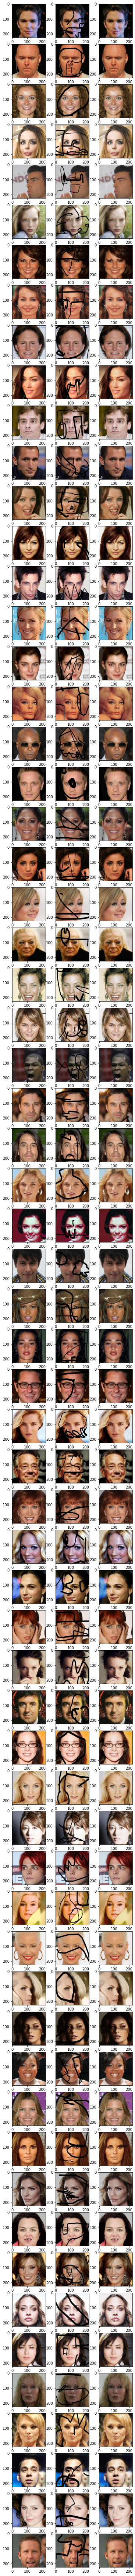

Mean PSNR value = 30.98196450301427
Mean SSIM value = 0.9667138645792858


In [97]:
def show_results(sample_idx):
    rows = 64
#     sample_idx = 1
    sample_images, sample_labels = d_test_gen[sample_idx]

    fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))
    mean_psnr = 0.0
    mean_ssim = 0.0
    for i in range(rows):
      impainted_image = d_model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
      axs[i][0].imshow(sample_labels[i])
      axs[i][1].imshow(sample_images[i])
      axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
      mean_psnr += PSNR(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))
      mean_ssim += SSIM(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]), multichannel=True)


    plt.show()
    print(f"Mean PSNR value = {mean_psnr/rows}")
    print(f"Mean SSIM value = {mean_ssim/rows}")
    
show_results(2)

In [98]:
def find(model, rows, sample_images, sample_labels):
  mean_psnr = 0.0
  mean_ssim = 0.0
  for i in range(rows):
    impainted_image = d_model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
    mean_psnr += PSNR(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))
    mean_ssim += SSIM(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]), multichannel=True)
  
  print("PSNR: ", mean_psnr/rows, "\nSSIM: ", mean_ssim/rows)
  return (mean_psnr/rows, mean_ssim/rows)

sample_idx = 1
rows = 64
n_iterations = 5
total_psnr = 0.0
total_ssim = 0.0;
for i in range(n_iterations):
    sample_images, sample_labels = d_test_gen[sample_idx]
    psnr, ssim = find(d_model, rows, sample_images, sample_labels)
    total_psnr += psnr
    total_ssim += ssim

print(f"Mean of Mean PSNR value = {total_psnr/n_iterations}")
print(f"Mean of Mean SSIM value = {total_ssim/n_iterations}")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Inputs have mismatched dtype.  Setting data_range based on im_true.



PSNR:  30.787478430340478 
SSIM:  0.9652460301200906
PSNR:  30.663505520127924 
SSIM:  0.9657049024542645
PSNR:  30.90498131469668 
SSIM:  0.9654751943002993
PSNR:  30.83602018428724 
SSIM:  0.9648776916996687
PSNR:  30.629264342316517 
SSIM:  0.9656577794460206
Mean of Mean PSNR value = 30.764249958353766
Mean of Mean SSIM value = 0.9653923196040688


In [99]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=d_history.history['dice_coef'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=d_history.history['val_dice_coef'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for image inpainting',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

In [100]:
# import cv2
# img = cv2.imread('../input/quick-draw-irregular-mask-dataset/qd_imd/train/00000_train.png',cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (256,256))
# img.shape

In [101]:
# for i in range(256):
#     if(len(img[img==i])):
#         print(i, len(img[img==i]))

# thresh = 127
# img_bw = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]

# for i in range(256):
#     if(len(img_bw[img_bw==i])):
#         print(i, len(img_bw[img_bw==i]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning:

Inputs have mismatched dtype.  Setting data_range based on im_true.



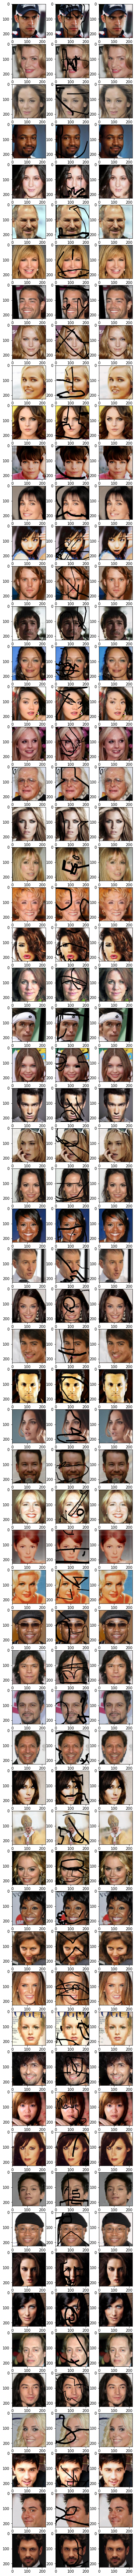

Mean PSNR value = 30.45093611599753
Mean SSIM value = 0.9643666681908246


In [102]:
show_results(3)

In [103]:
d_model.save("sha-sat-90_10_downstream.h5")

In [104]:
# tensorflow.python.framework.ops.Tensor